In [2]:
import pandas as pd
import glob
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

In [3]:
pd.options.display.float_format = '{:.2f}'.format
pd.set_option('display.max_columns', 50)

In [33]:
#Column selection
use_cols = [
    'tpep_pickup_datetime',
    'tpep_dropoff_datetime',
    'trip_distance',
    'fare_amount',
    'RatecodeID',
    'VendorID',
    'Airport_fee'
]

# Get all file paths
all_taxi_files = glob.glob('../../../DataSets/NY_taxi//*.parquet')

# Load all DataFrames into a list in memory
list_of_dataframes = [pd.read_parquet(f,columns=use_cols) for f in all_taxi_files]

# Combine them all at once
combined_taxi_df = pd.concat(list_of_dataframes, ignore_index=True)

print(f"Loaded {len(list_of_dataframes)} files.")
print("Combined DataFrame info:")
combined_taxi_df.info()

Loaded 13 files.
Combined DataFrame info:
<class 'pandas.DataFrame'>
RangeIndex: 48819974 entries, 0 to 48819973
Data columns (total 7 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   tpep_pickup_datetime   datetime64[us]
 1   tpep_dropoff_datetime  datetime64[us]
 2   trip_distance          float64       
 3   fare_amount            float64       
 4   RatecodeID             float64       
 5   VendorID               int32         
 6   Airport_fee            float64       
dtypes: datetime64[us](2), float64(4), int32(1)
memory usage: 2.4 GB


In [7]:
weather_df = pd.read_csv('../../../DataSets/Weather 2025/new york 2024-01-01 to 2025-08-31.csv', index_col = "datetime")
weather_df.head(2)

,name,tempmax,tempmin,temp,feelslikemax,feelslikemin,feelslike,dew,humidity,precip,precipprob,precipcover,preciptype,snow,snowdepth,windgust,windspeed,winddir,sealevelpressure,cloudcover,visibility,solarradiation,solarenergy,uvindex,severerisk,sunrise,sunset,moonphase,conditions,description,icon,stations
datetime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2024-01-01,new york,45.60,37.50,42.10,45.00,30.60,39.00,30.10,62.60,0.02,100,12.50,rain,0.00,0.00,15.40,10.00,314.60,1016.60,77.40,9.80,56.10,4.80,4,10,2024-01-01T07:19:47,2024-01-01T16:38:42,0.68,"Rain, Partially cloudy",Partly cloudy throughout the day with morning ...,rain,"72505394728,KJFK,KLGA,74486094789,F8726,KNYC,7..."
2024-01-02,new york,42.60,29.20,36.30,38.80,21.00,30.40,21.30,55.00,0.00,0,0.00,NaN,0.00,0.00,14.50,9.00,327.10,1017.90,5.80,9.90,63.50,5.40,4,10,2024-01-02T07:19:53,2024-01-02T16:39:33,0.72,Clear,Clear conditions throughout the day.,clear-day,"72505394728,KJFK,KLGA,74486094789,F8726,KNYC,7..."


In [ ]:
weather_df.describe()

,tempmax,tempmin,temp,feelslikemax,feelslikemin,feelslike,dew,humidity,precip,precipprob,precipcover,snow,snowdepth,windgust,windspeed,winddir,sealevelpressure,cloudcover,visibility,solarradiation,solarenergy,uvindex,severerisk,moonphase
count,609.00,609.00,609.00,609.00,609.00,609.00,609.00,609.00,609.00,609.00,609.00,609.00,609.00,609.00,609.00,609.00,609.00,609.00,609.00,609.00,609.00,609.00,609.00,609.00
mean,64.04,51.56,57.49,63.21,48.12,55.34,42.27,59.34,0.11,39.57,9.91,0.05,0.05,27.66,15.29,194.68,1016.21,58.75,9.16,158.77,13.71,6.21,12.87,0.48
std,17.75,16.21,16.68,20.47,20.17,20.00,18.53,14.85,0.29,48.94,18.16,0.36,0.28,8.00,4.78,103.77,7.38,25.96,1.38,96.92,8.38,2.89,9.30,0.29
min,19.70,12.40,16.70,10.50,-2.60,5.20,-3.50,29.30,0.00,0.00,0.00,0.00,0.00,8.30,5.30,0.60,991.90,3.70,1.90,8.90,0.80,0.00,10.00,0.00
25%,49.50,38.60,43.90,47.00,31.90,39.00,28.00,47.60,0.00,0.00,0.00,0.00,0.00,22.40,11.70,93.10,1011.90,38.80,9.20,71.20,6.20,4.00,10.00,0.24
50%,66.50,51.70,59.60,66.50,51.70,59.40,43.10,58.30,0.00,0.00,0.00,0.00,0.00,27.70,14.60,208.40,1016.10,58.50,9.90,137.90,11.90,6.00,10.00,0.48
75%,79.50,65.40,72.00,79.50,65.40,72.00,57.50,71.20,0.06,100.00,12.50,0.00,0.00,32.20,18.00,291.30,1020.50,80.20,9.90,243.60,21.00,9.00,10.00,0.75
max,98.50,82.60,89.60,103.40,85.20,92.70,73.40,92.00,3.16,100.00,95.83,5.30,3.10,52.50,36.10,359.40,1046.30,100.00,9.90,358.10,30.90,10.00,100.00,0.98


In [8]:
precip_mask = weather_df["preciptype"].isna()==False
strong_wind = weather_df["windspeed"]>=25.0
weather_df["has_precip"] = precip_mask.astype(int)
weather_df["strong_wind"] = strong_wind.astype(int)

In [9]:
ny_weather_2025 = weather_df[["has_precip", "strong_wind"]]
ny_weather_2025.head()

,has_precip,strong_wind
datetime,,
2024-01-01,1,0
2024-01-02,0,0
2024-01-03,0,0
2024-01-04,0,1
2024-01-05,0,0


In [10]:
holidays_df = pd.read_csv('../../../DataSets/US Holidays/US_holidays_2024_2025.csv', index_col="DATE") 
holidays_df.head()

,NAME OF HOLIDAY
DATE,
"January 1, 2025",New Year's Day
"January 20, 2025",Martin Luther King Jr. Day
"February 14, 2025",Valentine's Day
"February 17, 2025",Washington's Birthday
"March 17, 2025",St. Patrick's Day


In [38]:
#Data preprocessing
#Removing negative values from fare_amount and also 0 values from trip_distance/trip_duration_minutes values
df_for_analysis = combined_taxi_df[
    (combined_taxi_df["fare_amount"]>=0)
    &(combined_taxi_df["trip_distance"]>0)
    &(combined_taxi_df["tpep_pickup_datetime"]>='2024-07-01')
    ].copy()
df_for_analysis.info()

<class 'pandas.DataFrame'>
Index: 45809280 entries, 0 to 48819973
Data columns (total 7 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   tpep_pickup_datetime   datetime64[us]
 1   tpep_dropoff_datetime  datetime64[us]
 2   trip_distance          float64       
 3   fare_amount            float64       
 4   RatecodeID             float64       
 5   VendorID               int32         
 6   Airport_fee            float64       
dtypes: datetime64[us](2), float64(4), int32(1)
memory usage: 2.6 GB


In [39]:
# Filter out all RatecodeID<7 and VendorID in 1 and 2
standart_fare = (df_for_analysis["RatecodeID"]<7) & (df_for_analysis["VendorID"]<3)

columns_to_keep = [
    "tpep_pickup_datetime","trip_distance", "fare_amount"
]

df_for_analysis = df_for_analysis.loc[standart_fare, columns_to_keep]
df_for_analysis = df_for_analysis.reset_index(drop=True)

In [36]:
df_for_analysis.info(show_counts=True)

<class 'pandas.DataFrame'>
RangeIndex: 38144125 entries, 0 to 38144124
Data columns (total 3 columns):
 #   Column                Non-Null Count     Dtype         
---  ------                --------------     -----         
 0   tpep_pickup_datetime  38144125 non-null  datetime64[us]
 1   trip_distance         38144125 non-null  float64       
 2   fare_amount           38144125 non-null  float64       
dtypes: datetime64[us](1), float64(2)
memory usage: 873.0 MB


In [40]:
#DateTime preprocessing
#Create day_of_the_week
#Create is_weekend
#Trim time part

df_for_analysis["day_of_week"] = df_for_analysis["tpep_pickup_datetime"].dt.dayofweek 

df_for_analysis["is_weekend"] = df_for_analysis["day_of_week"].isin([5, 6]).astype(int)

df_for_analysis["ride_start_day"] = df_for_analysis["tpep_pickup_datetime"].dt.floor('D')

df_for_analysis.head()

,tpep_pickup_datetime,trip_distance,fare_amount,day_of_week,is_weekend,ride_start_day
0,2025-02-01 00:12:18,3.12,19.80,5,1,2025-02-01
1,2025-02-01 00:40:04,1.40,10.00,5,1,2025-02-01
2,2025-02-01 00:06:09,0.40,6.50,5,1,2025-02-01
3,2025-02-01 00:15:13,0.70,7.20,5,1,2025-02-01
4,2025-02-01 00:02:52,4.19,19.80,5,1,2025-02-01


In [41]:
#DF group by day
taxi_df_prep_daily = df_for_analysis.groupby(
    ["ride_start_day", "day_of_week", "is_weekend"],
    as_index=False).agg(number_of_trips=('ride_start_day', 'size'))

taxi_df_prep_daily.set_index('ride_start_day', inplace=True)


In [42]:
# Merging taxi rides with weather table
taxi_df_prep_daily.index = pd.to_datetime(taxi_df_prep_daily.index)
ny_weather_2025.index = pd.to_datetime(ny_weather_2025.index)
holidays_df.index = pd.to_datetime(holidays_df.index)

taxi_df_daily = taxi_df_prep_daily.join(ny_weather_2025, how="left")
taxi_df_daily = taxi_df_daily.join(holidays_df, how="left")
taxi_df_daily['is_holiday'] = taxi_df_daily['NAME OF HOLIDAY'].notna().astype(int)
taxi_df_daily['is_christmax'] = (taxi_df_daily['NAME OF HOLIDAY']=="Christmas Day").astype(int)
taxi_df_daily['is_independence_day'] = (taxi_df_daily['NAME OF HOLIDAY']=="Independence Day").astype(int)
taxi_df_daily['is_new_year'] = (taxi_df_daily['NAME OF HOLIDAY']=="New Year's Day").astype(int)
taxi_df_daily['is_valentine_day'] = (taxi_df_daily['NAME OF HOLIDAY']=="Valentine's Day").astype(int)
taxi_df_daily = taxi_df_daily.drop(columns='NAME OF HOLIDAY')
taxi_df_daily.head()

,day_of_week,is_weekend,number_of_trips,has_precip,strong_wind,is_holiday,is_christmax,is_independence_day,is_new_year,is_valentine_day
ride_start_day,,,,,,,,,,
2024-07-01,0,0,74955,0,0,0,0,0,0,0
2024-07-02,1,0,78380,0,0,0,0,0,0,0
2024-07-03,2,0,71182,0,0,0,0,0,0,0
2024-07-04,3,0,51267,0,0,1,0,1,0,0
2024-07-05,4,0,64768,1,0,0,0,0,0,0


In [43]:
taxi_df_daily = taxi_df_daily.asfreq('D')

In [44]:
#Split dataset for train and fact table

forecast_data = (taxi_df_daily.index >= '2025-07-15') & (taxi_df_daily.index <'2025-07-31')
test_data = taxi_df_daily.index < '2025-07-15'
fact_data_table = taxi_df_daily[forecast_data]
test_data_table = taxi_df_daily[test_data].copy()

test_data_table.head()

,day_of_week,is_weekend,number_of_trips,has_precip,strong_wind,is_holiday,is_christmax,is_independence_day,is_new_year,is_valentine_day
ride_start_day,,,,,,,,,,
2024-07-01,0,0,74955,0,0,0,0,0,0,0
2024-07-02,1,0,78380,0,0,0,0,0,0,0
2024-07-03,2,0,71182,0,0,0,0,0,0,0
2024-07-04,3,0,51267,0,0,1,0,1,0,0
2024-07-05,4,0,64768,1,0,0,0,0,0,0


<Axes: title={'center': 'Daily Number of Taxi Trips'}, xlabel='Date', ylabel='Number of trips'>

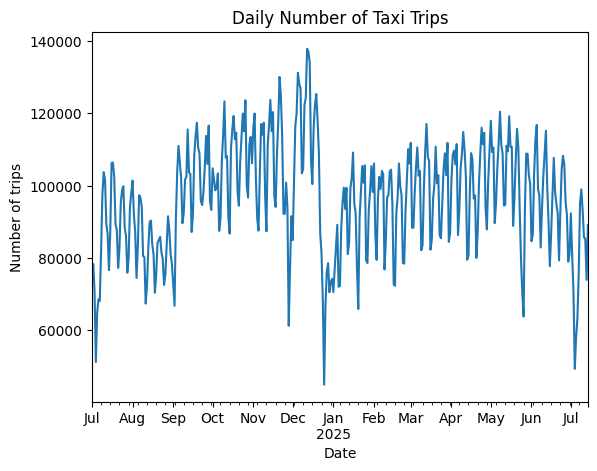

In [45]:
date_filter = (test_data_table.index>= '2024-01-01')&(test_data_table.index< '2025-09-01')
test_data_table[date_filter]['number_of_trips'].plot(
    kind = "line",
    title='Daily Number of Taxi Trips',
    xlabel = "Date",
    ylabel = "Number of trips"
)

In [46]:
#Test for stationarity
result = adfuller(test_data_table['number_of_trips'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:')
for key, value in result[4].items():
    print(f'   {key}: {value}')

ADF Statistic: -3.2590602384808935
p-value: 0.016810651634333096
Critical Values:
   1%: -3.448544133483233
   5%: -2.8695574079525565
   10%: -2.5710411593052713


In [47]:
# #first-order differencing
# test_data_table['diff'] = test_data_table['number_of_trips'].diff()

# result = adfuller(test_data_table['diff'].dropna())
# print('ADF Statistic:', result[0])
# print('p-value:', result[1])

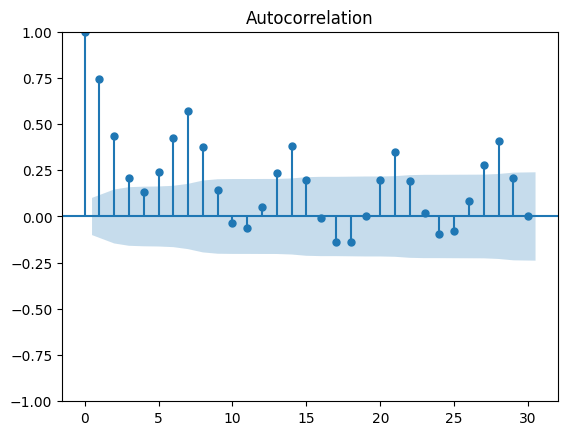

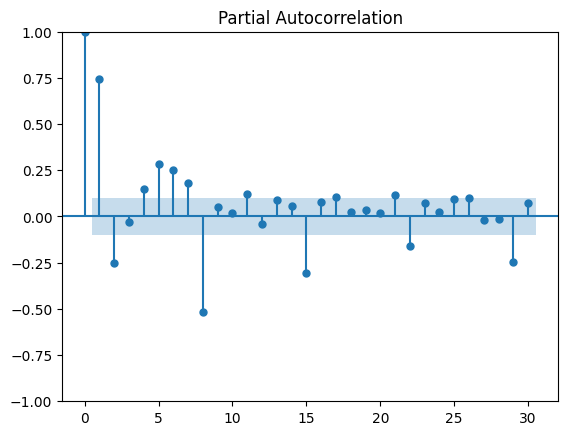

In [48]:
#autocorrelation plots to estimate p, q (non-seasonal) and P, Q (seasonal):
plot_acf(test_data_table['number_of_trips'], lags=30)
plot_pacf(test_data_table['number_of_trips'], lags=30)
plt.show()

In [49]:
exog = test_data_table[['has_precip']]#, 'is_holiday']]  #'is_independence_day','is_christmax',  'is_new_year']]
future_exog = fact_data_table[['has_precip']] #, 'is_holiday']] #'is_independence_day', 'is_christmax', 'is_new_year']]

In [50]:
print(test_data_table.index.freq)

<Day>


In [51]:
model = SARIMAX(test_data_table['number_of_trips'],
                order=(1,0,2),
                seasonal_order=(0,1,1,7),
                exog=exog,
                freq='D',
                enforce_stationarity=False,
                enforce_invertibility=False)
results = model.fit()
print(results.summary())

                                      SARIMAX Results                                      
Dep. Variable:                     number_of_trips   No. Observations:                  379
Model:             SARIMAX(1, 0, 2)x(0, 1, [1], 7)   Log Likelihood               -3733.116
Date:                             Tue, 24 Feb 2026   AIC                           7478.233
Time:                                     12:34:11   BIC                           7501.583
Sample:                                 07-01-2024   HQIC                          7487.515
                                      - 07-14-2025                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
has_precip  1987.4778    801.224      2.481      0.013     417.108    3557.848
ar.L1          0.7694      

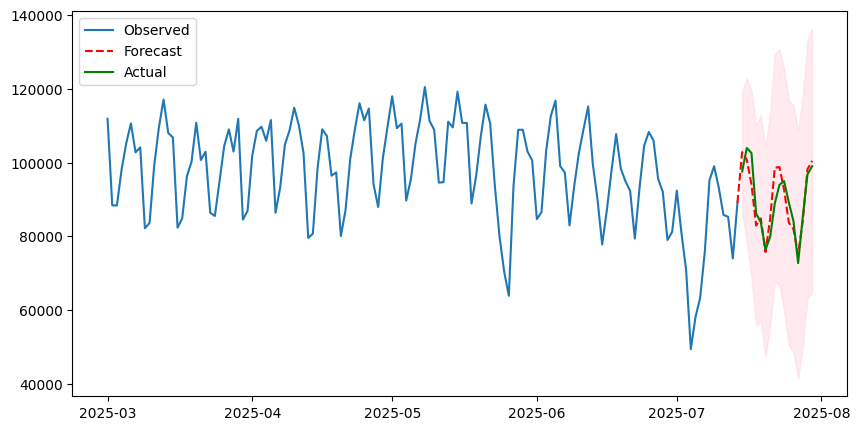

In [52]:
### forecast + visualization
forecast = results.get_forecast(steps=16, exog = future_exog)  # next 2 weeks
pred_ci = forecast.conf_int()

last_date = test_data_table.index[-1]
last_value = test_data_table['number_of_trips'].iloc[-1]
forecast_to_plot = pd.concat([pd.Series({last_date: last_value}), forecast.predicted_mean])

#number of days to plot
mask = test_data_table.index>= '2025-03-01'
#plot
plt.figure(figsize=(10,5))
plt.plot(test_data_table[mask]['number_of_trips'], label='Observed')
plt.plot(forecast_to_plot, label='Forecast', color='red', linestyle='--')
plt.plot(fact_data_table['number_of_trips'], label='Actual', color='green')
plt.fill_between(pred_ci.index,
                 pred_ci.iloc[:,0],
                 pred_ci.iloc[:,1], color='pink', alpha=0.3)
plt.legend()
plt.show()

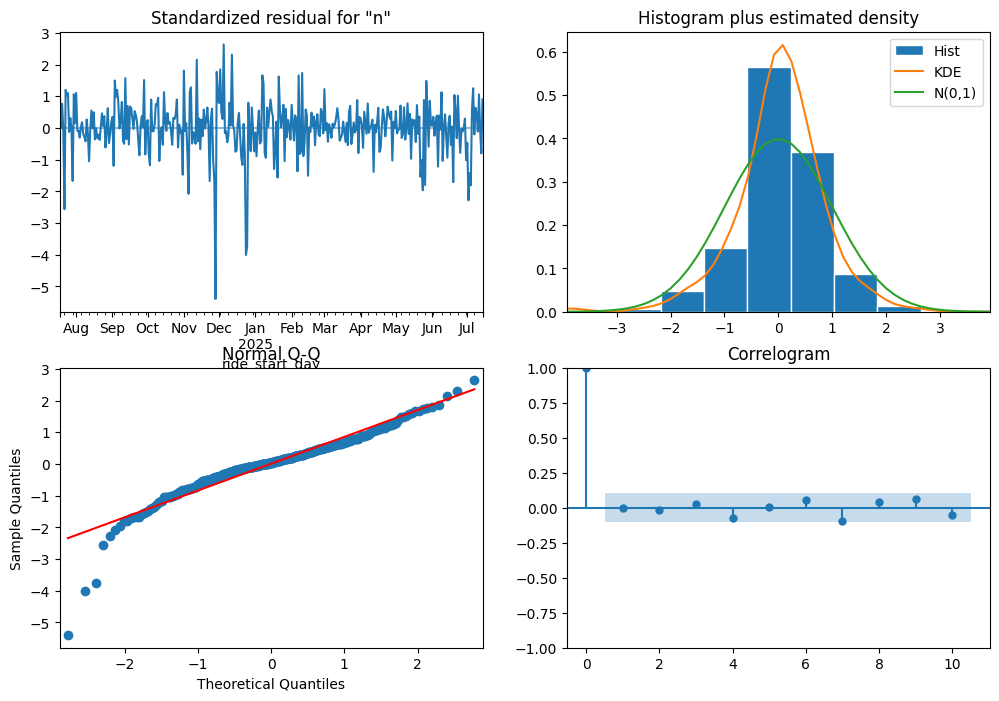

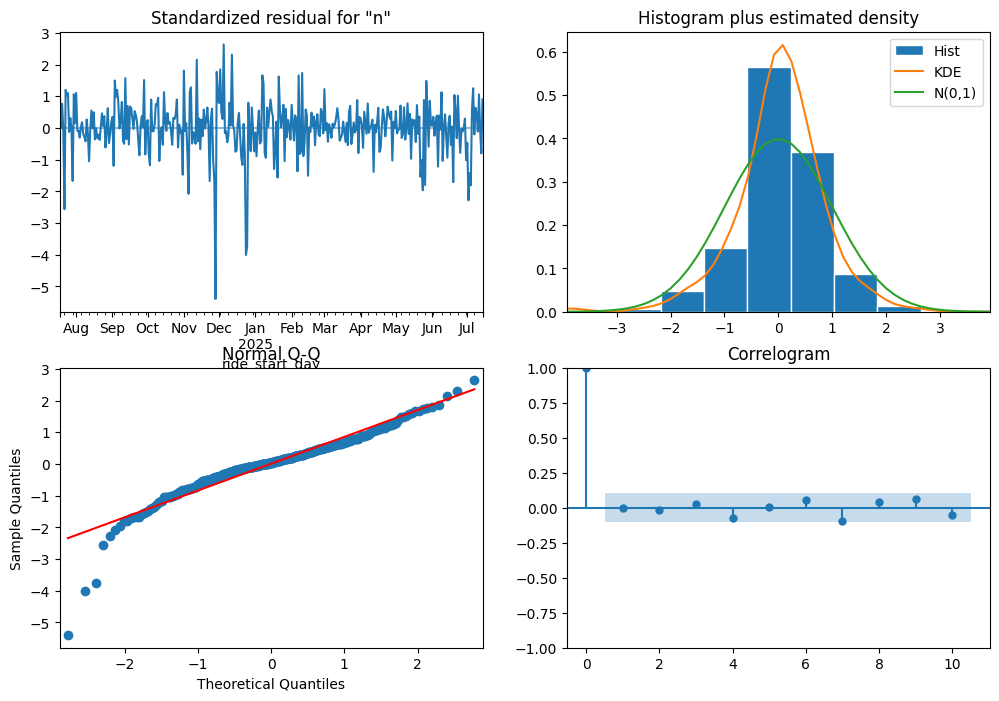

In [53]:
results.plot_diagnostics(figsize=(12,8))

In [54]:
#Error check
y_true = fact_data_table['number_of_trips']
y_pred = forecast.predicted_mean


# MAE (Mean Absolute Error)
mae = mean_absolute_error(y_true, y_pred)
print(f"Mean Absolute Error (MAE): {mae:,.0f} trips")

# RMSE (Root Mean Squared Error)
mse = mean_squared_error(y_true, y_pred)
# Then, take the square root of the MSE to get the RMSE
rmse = np.sqrt(mse)
print(f"Root Mean Squared Error (RMSE): {rmse:,.0f} trips")

# MAPE (Mean Absolute Percentage Error)
mape = mean_absolute_percentage_error(y_true, y_pred)
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2%}")

Mean Absolute Error (MAE): 3,603 trips
Root Mean Squared Error (RMSE): 4,433 trips
Mean Absolute Percentage Error (MAPE): 3.97%
